# Упражнение 6.1


В этой главе утверждается, что analyze1 требует времени пропорционально
n^3, а analyze2 - пропорционально n^2. Убедимся в этом, запуская их с несколькими разными массивами и засекая время работы.
В блокнотах Jupyter можно использовать "волшебную команду" %timeit.
Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.
Также поупражняемся с dct_iv и scipy.fftpack.dct.

Для начала импортируем необходимые библиотеки:

In [1]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

Далее создадим шумовой сигнал

In [2]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Затем создадим функцию отображения результатов анализа, которая аппроксимирует результат прямой линией:

In [3]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Затем начнем тестирование

Результаты для analyze1:



64
85.7 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
261 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.21 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
5.44 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
36.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
253 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
627 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.259530581855205

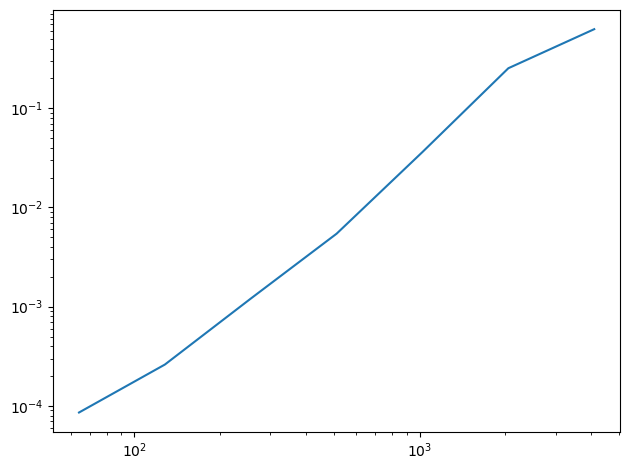

In [4]:
ns = 2 ** np.arange(6, 13)
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Однако, наклон получился близок не к 3, а к 2. Вероятно, это произошло из-за того, что в данном случае производительность np.linalg.solve близка к квадратичной

Напишем функцию для analyze2:

In [5]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Результаты для analyze2:

64
48.8 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
164 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
579 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
3.33 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
13.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
56 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
224 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.068101957204744

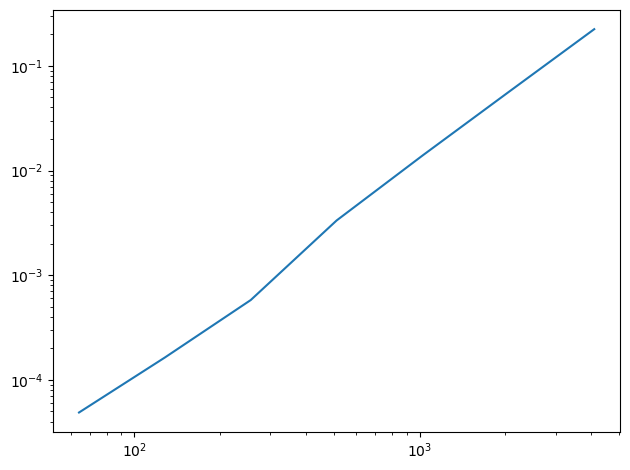

In [6]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

В итоге получили почти прямую линию с наклоном, близким к 2, как и ожидалось

Результаты тестирования scipy.fftpack.dct

64
6.56 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
7.02 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
7.67 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
9.17 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
11.7 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
2048
17.8 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
4096
30.7 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


0.3565688637731473

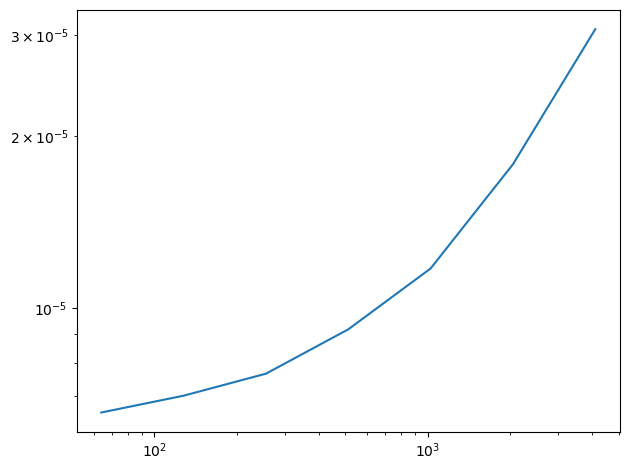

In [7]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)
    
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

По графику можно увидеть, что эта функция работает быстрее, время её работы пропорционально N * log(N).

Теперь проанализируем dct_iv

In [8]:
def dct_iv(ys, freqs, ts):
  N = len(ys)
  ts = (0.5 + np.arange(N))/N
  fs = (0.5 + np.arange(N))/2
  args = np.outer(ts,fs)
  M = np.cos(PI2*args)
  amps = np.dot(M, ys) / 2
  return amps

64
55.6 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
165 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
256
562 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
3.48 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
13.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
2048
55.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
223 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.0478803468200493

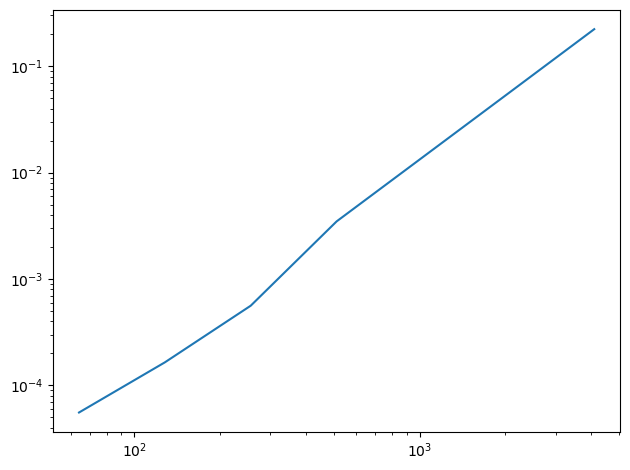

In [9]:
best4 = run_speed_test(ns, dct_iv)
plot_bests(ns, best4)

В итоге получили искривлённую линию с наклоном около 1.9.

# Упражнение 6.2


Oдно из основных применений ДКП - это сжатие звука и изображений.
В простейшей форме ДКП при сжатии работает следующим
образом:
1. Разбивает длинный сигнал на сегменты.
2. Вьчисляет ДКП каждого сегмента.
3. Определяет частотные компоненты с такой амплитудой, что
их не слышно, и удаляет их, сохраняя только оставшиеся частоты
и амплитуды.
4. При воспроизведении сигнала загружает частоты и амплитуды
каждого сегмента и применяет обратное ДКП.
Реализуйте версию этого алгоритма и примените его для записи
музыки или речи. Сколько компонент можно удалить до того, как
разница станет заметной?

Загрузим саму запись и послушаем:

In [10]:
from thinkdsp import read_wave

wave = read_wave('/content/648433__timouse__piano-loop-20.wav')
wave.make_audio()

FileNotFoundError: [Errno 2] No such file or directory: '/content/648433__timouse__piano-loop-20.wav'

Извлечем из неё сегмент

In [ ]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сигнала

In [ ]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Создадим функцию, которая убирает из ДКП частоты со значениями ниже заданного treshold

In [ ]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим эту функцию к заданному сигналу

In [ ]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=1)
seg_dct.plot(high=4000)

In [ ]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Звук остался практически неизменным при сжатии в 85%

Создадим функцию, которая позволит получить спектрограмму ДКП 

In [ ]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Теперь можно сжать все сегменты ДСП

In [ ]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.002)

Большинство сегментов удалось сжать на 40-60%

In [ ]:
wave2 = spectro.make_wave()
wave2.make_audio()

Если увеличить сжатие, то становятся заметны шумы

In [ ]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.008)

In [ ]:
wave2 = spectro.make_wave()
wave2.make_audio()

# Упражнение 6.3
В репозитории этой книги есть блокнот jupyter под названием
phase.ipynb, в котором исследуется влияние фазы на восприятие
звука. Прочтите этот блокнот и "погоняйте" примеры. Выберите
иной сегмент звука и повторите эксперименты. Можно ли найти некие
общие соотношения в фазовой структуре звука и его восприятии?

Импортируем необходимые библиотеки, загрузим и послушаем саму запись:

In [11]:
from thinkdsp import read_wave

wave = read_wave('/content/77685__juskiddink__anna-britta-sax.wav')
wave.make_audio()

FileNotFoundError: [Errno 2] No such file or directory: '/content/77685__juskiddink__anna-britta-sax.wav'

Выделим сегмент из исходной записи:

In [ ]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Напишем функции для вывода амплитуды, углов и waveform заданного спектра

In [ ]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

In [ ]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

Получим данные для оригинального сегмента

In [ ]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Напишем функцию для обнуления всех углов сегмента 

In [ ]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

In [ ]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

После обнуления углов сегмент звучит намного тише

Теперь напишем функцию для поворота углов на 1 радиан

In [ ]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

In [ ]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

После поворота углов сигнал кажется почти неизменным

Создадим функцию для рандомизации углов

In [ ]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

In [ ]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

К звуку изначальной записи добавилось эхо